### Outlier Factors for Device Profiling

In [62]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
epochs_per_batch = 50

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[df_all['time'] <= epochs_per_batch * time_epoch]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [63]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= epochs_per_batch * time_epoch * 2]['source computer'].values))) 

In [64]:
def group_scale_data(df, size_of_bin_seconds=60, addZeros=True, hosts=None, verbose=0):
    """
    :param size_of_bin_seconds: the time period of each bin,
                assumes the dataframe has a column names 'source computer' and a name 'byte count'
    :param addZeros: add values (0, 0) where no data has been received for this bucket
    :return: a dictionary containing for each host the features, the hosts 
    """
                     
    if hosts is None:
        hosts = np.array(list(set(df['source computer'].values)))

    bins = np.arange(df.index.min(), df.index.max() + size_of_bin_seconds + 1, size_of_bin_seconds)

    groups = df[['byte count','source computer']].groupby([np.digitize(df.index, bins),'source computer'])

    data = groups.count()
    data.columns = ['number of flows']
    data['mean(byte count)'] = groups.mean().values

    data_reset = data.reset_index()

    if verbose > 0:
        print('A total of', len(bins) - 1, 'time epochs have been encountered')
    
    len_hosts = len(hosts)
    intervals = int(len_hosts / 20)
    i = 0
    
    if addZeros:
        for host in hosts:
            if verbose > 0 and i % intervals == 0:
                print('Done with', i, 'hosts out of', len_hosts)
            i += 1

            for bin_i in range(1,len(bins)):
                if (bin_i, host) not in data.index:
                    new_row = [bin_i, host, 0.0, 0.0]
                    data_reset = data_reset.append(pd.DataFrame([new_row], columns=data_reset.columns), ignore_index=True )

    groupped_data = pd.DataFrame(data_reset.values[:,2:], columns=['number of flows', 'mean(byte count)'])
    groupped_data['epoch'] = data_reset['level_0']
    groupped_data['source computer'] = data_reset['source computer']

    # set parameters for next acquisition of data
    parameters = {}
    parameters['size_of_bin_seconds'] = size_of_bin_seconds
    parameters['hosts'] = hosts

    groupped_data = groupped_data.sample(frac=1)
    groupped_data['mean(byte count)'] = groupped_data['mean(byte count)'].values.astype(int)
    groupped_data['number of flows'] = groupped_data['number of flows'].values.astype(int)
    
    return groupped_data.sort_values(by=['epoch']), hosts, parameters

In [15]:
groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=time_epoch,
                                                    addZeros=True, verbose=1, hosts=hosts)

A total of 50 time epochs have been encountered
Done with 0 hosts out of 1894
Done with 94 hosts out of 1894
Done with 188 hosts out of 1894
Done with 282 hosts out of 1894
Done with 376 hosts out of 1894
Done with 470 hosts out of 1894
Done with 564 hosts out of 1894
Done with 658 hosts out of 1894
Done with 752 hosts out of 1894
Done with 846 hosts out of 1894
Done with 940 hosts out of 1894
Done with 1034 hosts out of 1894
Done with 1128 hosts out of 1894
Done with 1222 hosts out of 1894
Done with 1316 hosts out of 1894
Done with 1410 hosts out of 1894
Done with 1504 hosts out of 1894
Done with 1598 hosts out of 1894
Done with 1692 hosts out of 1894
Done with 1786 hosts out of 1894
Done with 1880 hosts out of 1894


In [16]:
groupped_data.head(5)

,number of flows,mean(byte count),epoch,source computer
85367,0,0,1,C2018
36282,0,0,1,C311
40359,0,0,1,C1342
104,1,1584,1,C23382
72784,0,0,1,C2329


In [17]:
print(np.max(groupped_data['number of flows'].values))
print(np.max(groupped_data['mean(byte count)'].values))

1135
28849384


In [1]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np

In [2]:
from sklearn.externals import joblib

#joblib.dump(groupped_data,'groupped_data_60_50.pkl')
groupped_data = joblib.load('groupped_data_60_50.pkl')

In [3]:
print(np.sum(groupped_data['mean(byte count)'] == 0))
print(len(groupped_data['mean(byte count)']))
print(np.max(groupped_data['mean(byte count)']))

73208
94700
28849384


In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1000))
scaler.fit([[x] for x in groupped_data['mean(byte count)'].values])
groupped_data['mean(byte count)'] = scaler.transform([[x] for x in groupped_data['mean(byte count)'].values]).astype(int)

In [4]:
np.sum(groupped_data['mean(byte count)'] == 0)

73208

In [7]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16

def plot_points(data, em=None):
    rcParams['figure.figsize'] = 16, 9
    data_hashable = [tuple(x) for x in data]
    total_points = len(data_hashable)

    values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
    counts = np.array(list(Counter(data_hashable).values()))

    for i in range(len(values)):
        plt.scatter(values[i][0], values[i][1], s=20, color='blue')
        
    if em:
        for i, lambda_i in enumerate(em.lambdas):
            plt.scatter(lambda_i[0], lambda_i[1], s=em.gammas[i]*1000, linewidth=4, color='red', marker='x')

        blue_patch = mpatches.Patch(color='blue', label='Data points')
        red_patch = mpatches.Patch(color='red', label='Centers of Distribution')
        plt.legend(handles=[red_patch, blue_patch], fontsize=18)
    else:
        blue_patch = mpatches.Patch(color='blue', label='Data points')
        plt.legend(handles=[blue_patch], fontsize=18)
    
    plt.ylabel('average number of bytes')
    plt.xlabel('number of flows')
    plt.show()
    

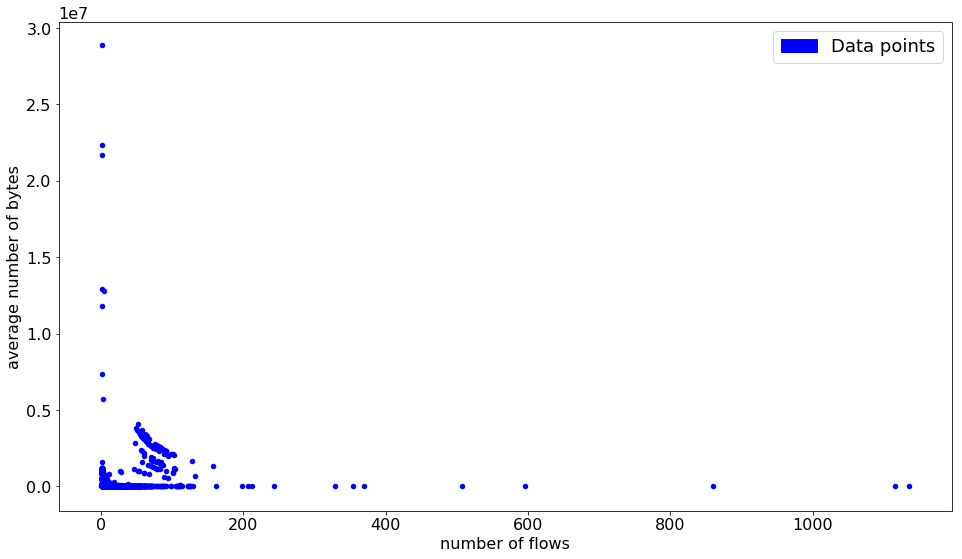

In [8]:
plot_points(groupped_data.values[:, :2])

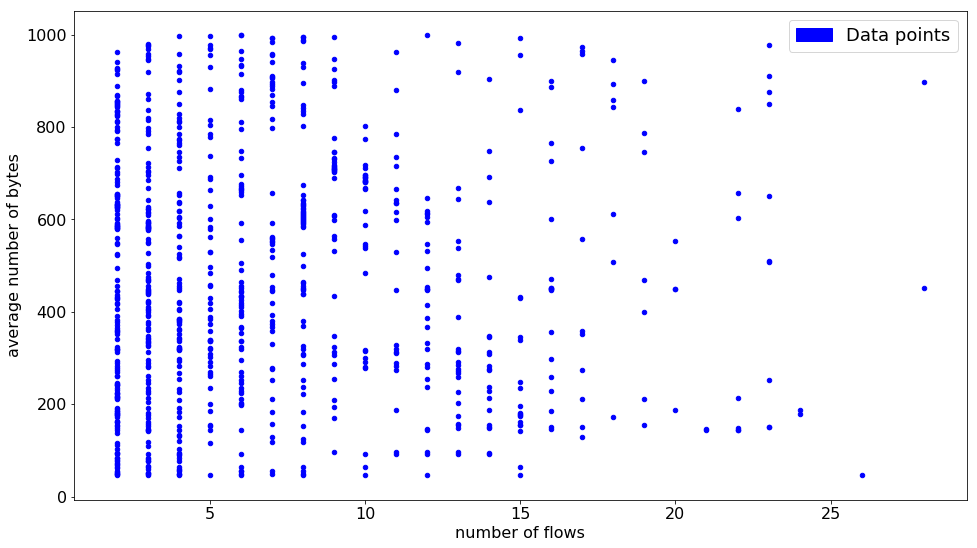

In [9]:
test = groupped_data[groupped_data['number of flows'] > 1].copy()

small_points = test[(test['mean(byte count)'] < 1000) & (test['number of flows'] < 30)].values[:, :2]
plot_points(small_points)

In [10]:
len(small_points)

4713

In [85]:
import scipy.stats.distributions
from math import log
import sys
import numpy as np


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    if return_value == 0:
        return sys.float_info.epsilon
    return return_value


class EM:
    def __init__(self, lambdas, gammas, x, 
                 convergence_error=0.0001, verbose=0):

        self.convergence_error = convergence_error
        
        self.lambdas = np.vstack(lambdas)
        self.gammas = np.array(gammas)
        self.m = len(gammas)
        self.x = x

    def _calculate_probabilities(self):
        for i, x_i in enumerate(self.x):
            self.probabilities[i] = np.sum(self.gammas * np.array([poisson(x_i, lambda_i) for lambda_i in self.lambdas]))

    def _calculate_likelihood(self):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in self.x:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def _calculate_participation(self):
        f = np.zeros(shape=(len(self.x), len(self.lambdas)))
        for i, x_i in enumerate(self.x):
            participation = self.gammas * np.array([poisson(x_i, lambda_i) for lambda_i in self.lambdas])
            total_x = np.sum(participation)
            if total_x == 0:
                participation = np.array([1/self.m] * self.m)
                total_x = 1
            f[i] = participation / total_x
        return f

    def run(self):
        previous_likelihood = self._calculate_likelihood()
        while True:
            f = self._calculate_participation()
            temp_sum = f.sum(axis=0)
            self.gammas = temp_sum / len(self.x)

            temp = np.zeros(shape=(len(self.lambdas), len(self.lambdas[0])))
            for i, x_i in enumerate(self.x):
                temp = temp + np.vstack([x_i * f_i for f_i in f[i]])
                
            self.lambdas = np.vstack([temp[i] / temp_i for i, temp_i in enumerate(temp_sum)])

            new_likelihood = self._calculate_likelihood()
            convergence = new_likelihood / previous_likelihood - 1
            print('convergence', convergence)
            if - self.convergence_error < convergence < self.convergence_error:
                break
                
            previous_likelihood = new_likelihood


In [89]:
em = EM([[0,0],[20, 500]], [0.6, 0.4] , small_points[:1000], convergence_error=0.1)

em.run()

print(em.gammas)
print(em.lambdas)

convergence 1.438802952467492
convergence -0.6269466542208446
convergence 0.02474689228989635
[ 0.59717771  0.40282229]
[[3.432161004493883 130.4974729653897]
 [4.1243744231717745 653.1361935294545]]


In [54]:
def real_poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.logpmf(x_i, l_i)
    return return_value
        
print(real_poisson([100, 200], [0, 0]))
print(real_poisson([100, 200], [25, 2000]))
print(real_poisson([100, 200], [75, 2000]))
print(real_poisson([100, 200], [25, 2100000]))
print(real_poisson([100, 200], [75, 2100000]))
print(real_poisson([100, 2100000], [100, 2000000]))

inf
89785.4006434
9388.68770428
140251835.752
14665866.3478
7951.30247781


In [61]:
scipy.stats.distributions.poisson.pmf(100, 1000)

5.4389421808262275e-293

In [23]:
mixtures = 3

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\kplusplus.py:43: RuntimeWarning: overflow encountered in double_scalars
  return np.array([1/poisson(x, center) - 1/max_value for x in self.x])


Centers found: 3


In [24]:
kplusplus.centers

[array([0, 0], dtype=object),
 array([1, 278], dtype=object),
 array([3, 46], dtype=object)]

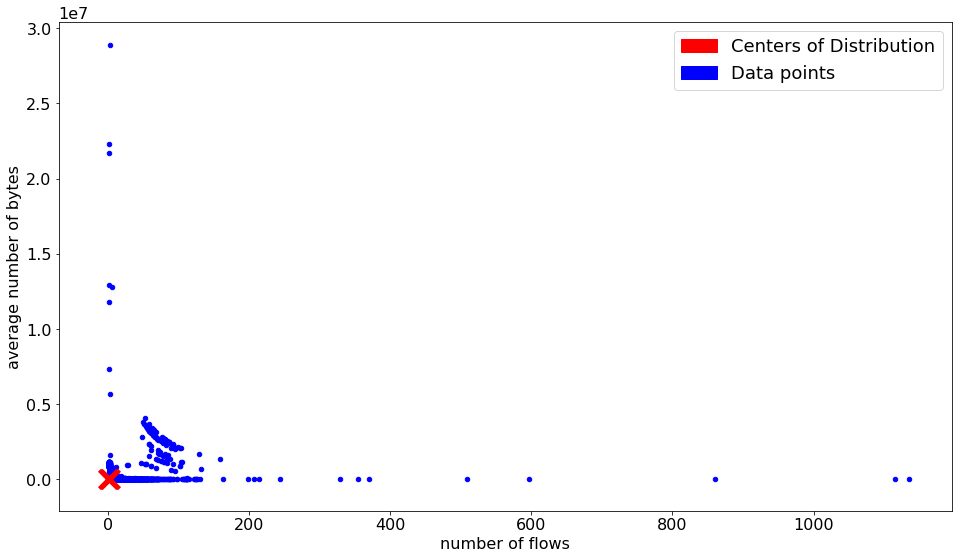

In [25]:
test = int(len(set(groupped_data['source computer'].values)))

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, test, n_clusters=8, verbose=1, update_power=0.5)

plot_points(groupped_data.values[:, :2], onlineEM)

In [14]:
data = groupped_data.values[:,[0,1,3]]

onlineEM.fit(data)

Running for data till position 1894 from total 94700
Running for data till position 3788 from total 94700
Running for data till position 5682 from total 94700
Running for data till position 7576 from total 94700
Running for data till position 9470 from total 94700
Running for data till position 11364 from total 94700
Running for data till position 13258 from total 94700
Running for data till position 15152 from total 94700
Running for data till position 17046 from total 94700
Running for data till position 18940 from total 94700
Running for data till position 20834 from total 94700
Running for data till position 22728 from total 94700
Running for data till position 24622 from total 94700
Running for data till position 26516 from total 94700
Running for data till position 28410 from total 94700
Running for data till position 30304 from total 94700
Running for data till position 32198 from total 94700
Running for data till position 34092 from total 94700
Running for data till position 35

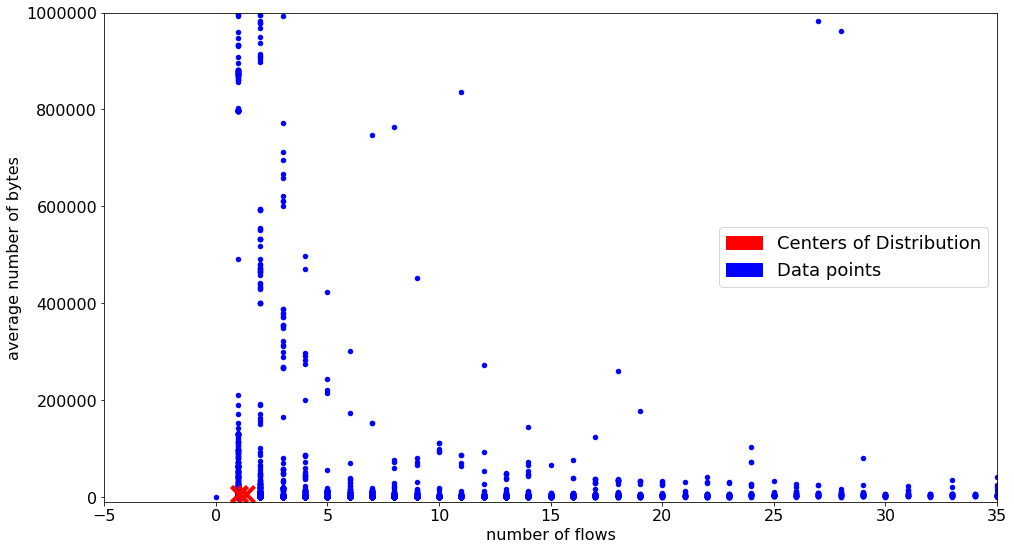

In [15]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16

def plot_points(data, em=None):
    rcParams['figure.figsize'] = 16, 9
    data_hashable = [tuple(x) for x in data]
    total_points = len(data_hashable)

    values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
    counts = np.array(list(Counter(data_hashable).values()))

    for i in range(len(values)):
        plt.scatter(values[i][0], values[i][1], s=20, color='blue')
        
    if em:
        for i, lambda_i in enumerate(em.lambdas):
            plt.scatter(lambda_i[0], lambda_i[1], s=em.gammas[i]*1000, linewidth=4, color='red', marker='x')

        blue_patch = mpatches.Patch(color='blue', label='Data points')
        red_patch = mpatches.Patch(color='red', label='Centers of Distribution')
        plt.legend(handles=[red_patch, blue_patch], fontsize=18)
    else:
        blue_patch = mpatches.Patch(color='blue', label='Data points')
        plt.legend(handles=[blue_patch], fontsize=18)
    
    plt.ylabel('average number of bytes')
    plt.xlabel('number of flows')
    plt.xlim([-5,35])
    plt.ylim([-10000,1000000])
    plt.show()
    
plot_points(groupped_data.values[:, :2], onlineEM)

In [16]:
print(onlineEM.lambdas)
print(onlineEM.gammas)

[[1.356395873089303 5622.727987139797]
 [1.0185045096335517 5761.876688005606]
 [1.0210386743991349 5762.871690621456]
 [1.0485776979958936 5752.886424290694]]
[ 0.26206403  0.24585095  0.24593804  0.24614698]


In [17]:
total = 0
for i in range(1):
    
    total += np.sum(groupped_data['number of flows'] == i)
    
print(total)

73208


In [18]:
np.sum(groupped_data['number of flows'] == 0)

73208